In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

# Objectif du notebook

Comparer les différentes modélisation possible sur la variable **consommation** :

* SARIMAX avec des fonctions sinusoïdales correspondant aux saisons observées en régresseurs exogènes
* SARIMAX avec des données métier en régresseurs exogènes (chauffage).
* SARIMAX avec des données métier FILTREES en régresseurs exogènes
* SARIMAX sur le signal filtré par transformation de Fourier sans régresseur
* SARIMAX sur le signal filtré avec des données métier FILTREES en régresseurs exogènes
* Régression linéaire sur les données métiers FILTREES comme variables explicatives
* Régression linéaire sur la variable à expliquée FILTREE et avec les variables explicatives FILTREES.

**NOTA BENE :** Pour la période 3h, le calcul avec un modèle SARIMAX n'aboutit pas sans données exogènes en paramètre.

# Import du dataset original

In [2]:
df = pd.read_csv('./dataset/France_3H.csv',
                usecols = ['Dates', 'Consommation'])
df.head(1)

,Dates,Consommation
0,2013-01-01 00:00:00,57831.6


In [3]:
df['Dates'] = pd.to_datetime(df['Dates'], yearfirst = True)
df.set_index('Dates', inplace = True)

In [4]:
debut = dt.datetime(year = 2013, month = 1, day = 1)
fin = dt.datetime(year = 2020, month = 1, day = 1)

''

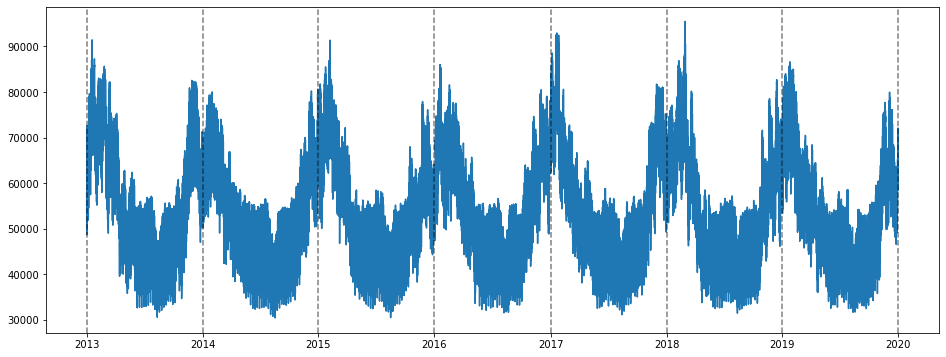

In [5]:
plt.figure(figsize=(16, 6))
plt.plot(df[(df.index >= debut) & (df.index < fin)])
for year in range(debut.year, fin.year + 1): 
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.5)
;

### Test de stationnarité

In [6]:
# la 2ème valeur donne la p_value (stationnaire si < 5%)
sm.tsa.stattools.adfuller(df)

(-3.6162747590302122,
 0.005457404309147549,
 49,
 25758,
 {'1%': -3.4306038998292085,
  '5%': -2.8616522161827964,
  '10%': -2.566829729367711},
 441892.87138022017)

### Coéfficients SARIMAX et saisonnalités

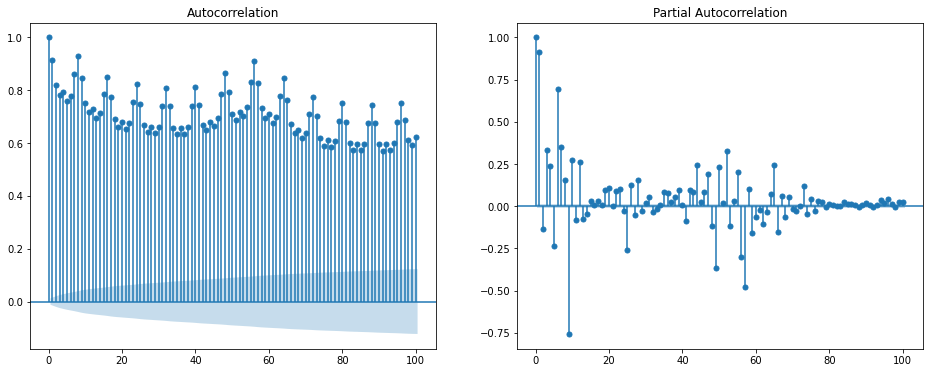

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
plot_acf(df, lags = 100, ax=ax1)
plot_pacf(df, lags = 100, ax=ax2)
plt.show()

**Saisonnalités :**
* 8 lags = 3h x 8 = 24h
* 56 lags = 3h x 8 x 7 = 1 semaine
* nature de la consommation : saisonnalité d'1 an

# Import du dataset filtré (Transformation de Fourier)

In [8]:
df_filtered = pd.read_csv('./dataset/France_3H_filtered.csv',
                usecols = ['Dates', 'Consommation'])
df_filtered.head(1)

,Dates,Consommation
0,2013-01-01 00:00:00,56094.121228


In [9]:
df_filtered['Dates'] = pd.to_datetime(df_filtered['Dates'], yearfirst = True)
df_filtered.set_index('Dates', inplace = True)

In [10]:
debut = dt.datetime(year = 2013, month = 1, day = 1)
fin = dt.datetime(year = 2020, month = 1, day = 1)

''

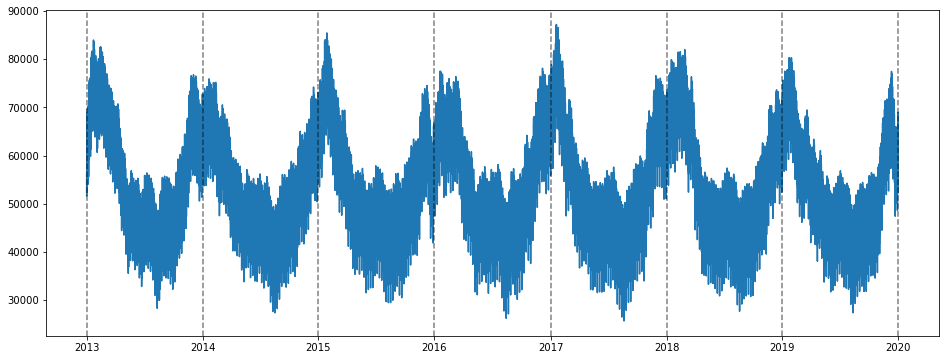

In [11]:
plt.figure(figsize=(16, 6))
plt.plot(df_filtered[(df_filtered.index >= debut) & (df_filtered.index < fin)])
for year in range(debut.year, fin.year + 1): 
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.5)
;

# Jeux d'entrainement et de test

In [12]:
df_train = df[(df.index >= debut) & (df.index < fin)]
df_test = df[df.index >= fin]

In [13]:
df_train_filter = df_filtered[(df_filtered.index >= debut) & (df_filtered.index < fin)]
df_test_filter = df_filtered[df_filtered.index >= fin]

In [14]:
fenetre = df_test.shape[0]

In [15]:
indice = df_test.index

In [16]:
bilan = df_test

# Paramètres SARIMAX

In [17]:
ordre = (2,0,0)
saison = (0,0,0,8)

# Régresseurs exogènes : sinus & cosinus suivant les saisonnalités

In [18]:
exog = pd.DataFrame({'date': df.index})
exog['date'] = pd.to_datetime(exog['date'])
# suivant saisonnalités
exog['sin_D'] = np.sin(2 * np.pi * exog.index / 8)
# exog['cos_D'] = np.cos(2 * np.pi * exog.index / 8)
exog['sin_W'] = np.sin(2 * np.pi * exog.index / 8 / 7)
# exog['cos_W'] = np.cos(2 * np.pi * exog.index / 8 / 7)
exog['sin_Y'] = np.sin(2 * np.pi * exog.index / 8 / 365.25)
# exog['cos_Y'] = np.cos(2 * np.pi * exog.index / 8 / 365.25)
exog.set_index('date', inplace = True)

In [19]:
# Split en jeu d'entrainement et jeu de test
exog_train = exog[(exog.index >= debut) & (exog.index < fin)]
exog_test = exog[exog.index >= fin]

<ipython-input-20-56416ee0eedf>:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  plt.plot(exog[(exog.index >= pd.datetime(2016, 1, 1)) & (exog.index < pd.datetime(2016, 1, 15))])


''

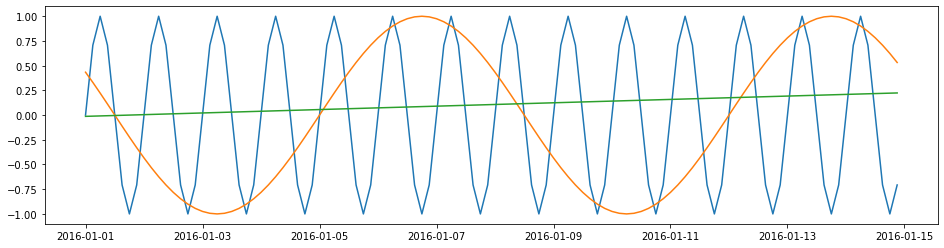

In [20]:
plt.figure(figsize=(16, 4))
plt.plot(exog[(exog.index >= pd.datetime(2016, 1, 1)) & (exog.index < pd.datetime(2016, 1, 15))])
# for year in range(debut.year, fin.year + 1): 
#     plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.5)
;

### SARIMAX

In [21]:
model_sinus = sm.tsa.SARIMAX(df_train.values,
                             exog = exog_train.values,
                             order = ordre,
                             seasonal_order = saison)
result_sinus = model_sinus.fit()

In [22]:
predict_sinus = result_sinus.predict(start = 1 ,
                                     end = fenetre,
                                     exog = exog_test.values)

In [23]:
predict_sinus = pd.DataFrame(predict_sinus, columns=['Conso_p_sinus'], index = indice)

In [24]:
bilan = pd.concat([bilan, predict_sinus], axis = 1)

### Erreur absolue

In [25]:
bilan['Err_sinus'] = np.abs(bilan['Conso_p_sinus'] - bilan['Consommation'])
bilan.describe()

,Consommation,Conso_p_sinus,Err_sinus
count,5360.000000,5360.000000,5360.000000
mean,51020.506312,53647.876286,6013.438265
std,10989.700761,12321.452627,5296.848785
min,29884.833333,29803.086683,1.474872
25%,42530.875000,43923.708246,1910.676489
50%,49206.833333,51890.864621,4483.259804
75%,58125.500000,61777.006628,8671.927843
max,87675.166667,92402.346002,28885.081967


# Régresseurs exogènes : données métier

In [26]:
exog = pd.read_csv('./exog/exog_3H_FR.csv', sep = ';',
                   usecols = ['Dates', 'Chauffage'])
exog.head(1)

,Dates,Chauffage
0,2013-01-01 00:00:00,-7.39391


In [27]:
exog['Dates'] = pd.to_datetime(exog['Dates'], yearfirst = True)
exog.set_index('Dates', inplace = True)
exog.tail(1)

,Chauffage
Dates,
2021-10-31 21:00:00,-12.14215


In [28]:
# Split en jeu d'entrainement et jeu de test
exog_train = exog[(exog.index >= debut) & (exog.index < fin)]
exog_test = exog[exog.index >= fin]

### SARIMAX

In [29]:
model_exog = sm.tsa.SARIMAX(df_train.values,
                       exog = exog_train.values,
                       # mle_regression = False, # Default = True
                       # simple_differencing = True, #Default = False
                       # state_regression = False,
                       order = ordre,
                       seasonal_order = saison)

In [30]:
result_exog = model_exog.fit(low_memory=True)

In [31]:
result_exog.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                20448
Model:               SARIMAX(2, 0, 0)   Log Likelihood             -201857.870
Date:                Wed, 04 May 2022   AIC                         403723.740
Time:                        10:19:43   BIC                         403755.442
Sample:                             0   HQIC                        403734.101
                              - 20448                                         
Covariance Type:               approx                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          -638.1717     14.552    -43.854      0.000    -666.694    -609.650
ar.L1          0.9522    7.3e-06    1.3e+05      0.000       0.952       0.952
ar.L2          0.0478   8.52e-07   5.62e+04      0.000       0.048       0.048
sigma2      2.197e+07   1.29e-09    1.7e+16      0.000     2.2e+07     2.2e+07
===================================================================================
Ljung-Box (L1) (Q):                   9.56   Jarque-Bera (JB):              1401.47
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.93   Skew:                             0.59
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
[2] Covariance matrix is singular or near-singular, with condition number 2.97e+36. Standard errors may be unstable.
"""

In [32]:
predict_exog = result_exog.predict(start = 1 ,
                               end = fenetre,
                               exog = exog_test.values)

In [33]:
predict_exog = pd.DataFrame(predict_exog, index = indice, columns = ['Conso_p_exog'])

In [34]:
bilan = pd.concat([bilan, predict_exog], axis = 1)

### Erreur absolue

In [35]:
bilan['Err_exog'] = np.abs(bilan['Conso_p_exog'] - bilan['Consommation'])
bilan.describe()

,Consommation,Conso_p_sinus,Err_sinus,Conso_p_exog,Err_exog
count,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000
mean,51020.506312,53647.876286,6013.438265,53854.338930,6142.650396
std,10989.700761,12321.452627,5296.848785,12109.450975,5366.287928
min,29884.833333,29803.086683,1.474872,31417.824937,1.132303
25%,42530.875000,43923.708246,1910.676489,44252.698980,2020.339979
50%,49206.833333,51890.864621,4483.259804,51531.266492,4498.261787
75%,58125.500000,61777.006628,8671.927843,62170.759466,9070.965385
max,87675.166667,92402.346002,28885.081967,92547.850553,28874.674981


# Régresseurs exogènes : données métier FILTREES

In [36]:
exog = pd.read_csv('./exog/exog_3H_FR_filtered.csv',# sep = ';',
                   usecols = ['Dates', 'Chauffage'])
exog.head(1)

,Dates,Chauffage
0,2013-01-01 00:00:00,-10.174321


In [37]:
exog['Dates'] = pd.to_datetime(exog['Dates'], yearfirst = True)
exog.set_index('Dates', inplace = True)

In [38]:
# Split en jeu d'entrainement et jeu de test
exog_train = exog[(exog.index >= debut) & (exog.index < fin)]
exog_test = exog[exog.index >= fin]

### SARIMAX

In [39]:
model_filter = sm.tsa.SARIMAX(df_train.values,
                       exog = exog_train.values,
                       # mle_regression = False, # Default = True
                       # simple_differencing = True, #Default = False
                       # state_regression = False,
                       order = ordre,
                       seasonal_order = saison)

In [40]:
result_filter = model_filter.fit(low_memory=True)

In [41]:
result_filter.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                20448
Model:               SARIMAX(2, 0, 0)   Log Likelihood             -201463.557
Date:                Wed, 04 May 2022   AIC                         402935.115
Time:                        10:20:06   BIC                         402966.817
Sample:                             0   HQIC                        402945.476
                              - 20448                                         
Covariance Type:               approx                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          -828.1196     14.963    -55.343      0.000    -857.447    -798.792
ar.L1          0.9147   5.87e-06   1.56e+05      0.000       0.915       0.915
ar.L2          0.0853   8.42e-07   1.01e+05      0.000       0.085       0.085
sigma2      2.114e+07    5.4e-10   3.92e+16      0.000    2.11e+07    2.11e+07
===================================================================================
Ljung-Box (L1) (Q):                  36.09   Jarque-Bera (JB):              1384.06
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.93   Skew:                             0.59
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
[2] Covariance matrix is singular or near-singular, with condition number 7.11e+36. Standard errors may be unstable.
"""

In [42]:
predict_filter = result_filter.predict(start = 1 ,
                               end = fenetre,
                               exog = exog_test.values)

In [43]:
predict_filter = pd.DataFrame(predict_filter, index = indice, columns = ['Conso_p_filter'])

In [44]:
bilan = pd.concat([bilan, predict_filter], axis = 1)

### Erreur absolue

In [45]:
bilan['Err_exog_filter'] = np.abs(bilan['Conso_p_filter'] - bilan['Consommation'])
bilan.describe()

,Consommation,Conso_p_sinus,Err_sinus,Conso_p_exog,Err_exog,Conso_p_filter,Err_exog_filter
count,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000
mean,51020.506312,53647.876286,6013.438265,53854.338930,6142.650396,53854.295734,6185.236567
std,10989.700761,12321.452627,5296.848785,12109.450975,5366.287928,12103.564777,5366.941474
min,29884.833333,29803.086683,1.474872,31417.824937,1.132303,31850.294481,0.019057
25%,42530.875000,43923.708246,1910.676489,44252.698980,2020.339979,44194.910429,2048.251754
50%,49206.833333,51890.864621,4483.259804,51531.266492,4498.261787,51384.351559,4585.171647
75%,58125.500000,61777.006628,8671.927843,62170.759466,9070.965385,62194.492893,9058.466978
max,87675.166667,92402.346002,28885.081967,92547.850553,28874.674981,93219.747186,29839.671293


# Target FILTREE sans régresseur

### SARIMAX

In [46]:
model_reduit_noreg = sm.tsa.SARIMAX(df_train_filter.values,
                       # exog = exog_train.values,
                       # mle_regression = False, # Default = True
                       # simple_differencing = True, #Default = False
                       # state_regression = False,
                       order = ordre,
                       seasonal_order = saison)

In [47]:
result_reduit_noreg = model_reduit_noreg.fit(low_memory=True)

In [48]:
result_reduit_noreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                20448
Model:               SARIMAX(2, 0, 0)   Log Likelihood             -200851.133
Date:                Wed, 04 May 2022   AIC                         401708.267
Time:                        10:20:08   BIC                         401732.044
Sample:                             0   HQIC                        401716.037
                              - 20448                                         
Covariance Type:               approx                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1082      0.007    159.476      0.000       1.095       1.122
ar.L2         -0.1119      0.007    -16.097      0.000      -0.125      -0.098
sigma2      1.991e+07   2.13e-14   9.34e+20      0.000    1.99e+07    1.99e+07
===================================================================================
Ljung-Box (L1) (Q):                  35.94   Jarque-Bera (JB):              1519.18
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.00   Skew:                             0.56
Prob(H) (two-sided):                  0.92   Kurtosis:                         2.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
[2] Covariance matrix is singular or near-singular, with condition number 9.66e+38. Standard errors may be unstable.
"""

In [49]:
predict_reduit_noreg = result_reduit_noreg.predict(start = 1 ,
                               end = fenetre,
                               # exog = exog_test.values
                            )

In [50]:
predict_reduit_noreg = pd.DataFrame(predict_reduit_noreg, index = indice, columns = ['Conso_p_reduit_noreg'])

In [51]:
bilan = pd.concat([bilan, predict_reduit_noreg], axis = 1)

### Erreur absolue

In [52]:
bilan['Err_filter_noreg'] = np.abs(bilan['Conso_p_reduit_noreg'] - bilan['Consommation'])
bilan.describe()

,Consommation,Conso_p_sinus,Err_sinus,Conso_p_exog,Err_exog,Conso_p_filter,Err_exog_filter,Conso_p_reduit_noreg,Err_filter_noreg
count,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000
mean,51020.506312,53647.876286,6013.438265,53854.338930,6142.650396,53854.295734,6185.236567,53802.352153,5641.889345
std,10989.700761,12321.452627,5296.848785,12109.450975,5366.287928,12103.564777,5366.941474,11487.157519,4902.289142
min,29884.833333,29803.086683,1.474872,31417.824937,1.132303,31850.294481,0.019057,26473.644563,1.237165
25%,42530.875000,43923.708246,1910.676489,44252.698980,2020.339979,44194.910429,2048.251754,44981.827443,1936.321468
50%,49206.833333,51890.864621,4483.259804,51531.266492,4498.261787,51384.351559,4585.171647,51557.071209,4201.379450
75%,58125.500000,61777.006628,8671.927843,62170.759466,9070.965385,62194.492893,9058.466978,62784.986348,8073.102225
max,87675.166667,92402.346002,28885.081967,92547.850553,28874.674981,93219.747186,29839.671293,84170.245362,30607.294978


# Target FILTREE avec Régresseurs exogènes : données métier FILTREES

In [53]:
exog = pd.read_csv('./exog/exog_3H_FR_filtered.csv',# sep = ';',
                   usecols = ['Dates', 'Chauffage'])
exog.head(1)

,Dates,Chauffage
0,2013-01-01 00:00:00,-10.174321


In [54]:
exog['Dates'] = pd.to_datetime(exog['Dates'], yearfirst = True)
exog.set_index('Dates', inplace = True)

In [55]:
# Split en jeu d'entrainement et jeu de test
exog_train = exog[(exog.index >= debut) & (exog.index < fin)]
exog_test = exog[exog.index >= fin]

### SARIMAX

In [56]:
model_reduit = sm.tsa.SARIMAX(df_train_filter.values,
                       exog = exog_train.values,
                       # mle_regression = False, # Default = True
                       # simple_differencing = True, #Default = False
                       # state_regression = False,
                       order = ordre,
                       seasonal_order = saison)

In [57]:
result_reduit = model_reduit.fit()

In [58]:
result_reduit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                20448
Model:               SARIMAX(2, 0, 0)   Log Likelihood             -199577.232
Date:                Wed, 04 May 2022   AIC                         399162.465
Time:                        10:20:31   BIC                         399194.167
Sample:                             0   HQIC                        399172.826
                              - 20448                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          -825.2449   3.54e-06  -2.33e+08      0.000    -825.245    -825.245
ar.L1          0.9169      0.009    107.579      0.000       0.900       0.934
ar.L2          0.0831      0.008     10.069      0.000       0.067       0.099
sigma2      1.757e+07   1.66e-10   1.06e+17      0.000    1.76e+07    1.76e+07
===================================================================================
Ljung-Box (L1) (Q):                  39.69   Jarque-Bera (JB):               982.92
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.99   Skew:                             0.42
Prob(H) (two-sided):                  0.57   Kurtosis:                         2.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.13e+31. Standard errors may be unstable.
"""

In [59]:
predict_reduit = result_reduit.predict(start = 1 ,
                               end = fenetre,
                               exog = exog_test.values)

In [60]:
predict_reduit = pd.DataFrame(predict_reduit, index = indice, columns = ['Conso_p_reduit'])

In [61]:
bilan = pd.concat([bilan, predict_reduit], axis = 1)

### Erreur absolue

In [62]:
bilan['Err_filter_exog_filter'] = np.abs(bilan['Conso_p_reduit'] - bilan['Consommation'])
bilan.describe()

,Consommation,Conso_p_sinus,Err_sinus,Conso_p_exog,Err_exog,Conso_p_filter,Err_exog_filter,Conso_p_reduit_noreg,Err_filter_noreg,Conso_p_reduit,Err_filter_exog_filter
count,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000
mean,51020.506312,53647.876286,6013.438265,53854.338930,6142.650396,53854.295734,6185.236567,53802.352153,5641.889345,53999.111277,5855.293656
std,10989.700761,12321.452627,5296.848785,12109.450975,5366.287928,12103.564777,5366.941474,11487.157519,4902.289142,11482.051642,5011.123701
min,29884.833333,29803.086683,1.474872,31417.824937,1.132303,31850.294481,0.019057,26473.644563,1.237165,28447.154750,0.405391
25%,42530.875000,43923.708246,1910.676489,44252.698980,2020.339979,44194.910429,2048.251754,44981.827443,1936.321468,44732.696120,2079.983700
50%,49206.833333,51890.864621,4483.259804,51531.266492,4498.261787,51384.351559,4585.171647,51557.071209,4201.379450,51678.643540,4545.047521
75%,58125.500000,61777.006628,8671.927843,62170.759466,9070.965385,62194.492893,9058.466978,62784.986348,8073.102225,62994.535300,8475.750953
max,87675.166667,92402.346002,28885.081967,92547.850553,28874.674981,93219.747186,29839.671293,84170.245362,30607.294978,85860.418499,32079.567988


# Régression linéaire avec Régresseurs exogènes : données métier FILTREES 

In [63]:
exog = pd.read_csv('./exog/exog_3H_FR_filtered.csv',# sep = ';',
                   usecols = ['Dates', 'Chauffage'])
exog.head(1)

,Dates,Chauffage
0,2013-01-01 00:00:00,-10.174321


In [64]:
exog['Dates'] = pd.to_datetime(exog['Dates'], yearfirst = True)
exog.set_index('Dates', inplace = True)

In [65]:
# Split en jeu d'entrainement et jeu de test
exog_train = exog[(exog.index >= debut) & (exog.index < fin)]
exog_test = exog[exog.index >= fin]

In [66]:
LinReg = LinearRegression()
LinReg.fit(exog_train, df_train)
predict_lr = LinReg.predict(exog_test)

In [67]:
predict_lr = pd.DataFrame(predict_lr, index = indice, columns = ['Conso_p_LinReg'])

In [68]:
bilan = pd.concat([bilan, predict_lr], axis = 1)

### Erreur absolue

In [69]:
bilan['Err_LinReg'] = np.abs(bilan['Conso_p_LinReg'] - bilan['Consommation'])
bilan.describe()

,Consommation,Conso_p_sinus,Err_sinus,Conso_p_exog,Err_exog,Conso_p_filter,Err_exog_filter,Conso_p_reduit_noreg,Err_filter_noreg,Conso_p_reduit,Err_filter_exog_filter,Conso_p_LinReg,Err_LinReg
count,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000
mean,51020.506312,53647.876286,6013.438265,53854.338930,6142.650396,53854.295734,6185.236567,53802.352153,5641.889345,53999.111277,5855.293656,53493.577458,7429.970556
std,10989.700761,12321.452627,5296.848785,12109.450975,5366.287928,12103.564777,5366.941474,11487.157519,4902.289142,11482.051642,5011.123701,7266.775036,5261.916358
min,29884.833333,29803.086683,1.474872,31417.824937,1.132303,31850.294481,0.019057,26473.644563,1.237165,28447.154750,0.405391,32379.929778,1.846277
25%,42530.875000,43923.708246,1910.676489,44252.698980,2020.339979,44194.910429,2048.251754,44981.827443,1936.321468,44732.696120,2079.983700,48141.643620,3165.826713
50%,49206.833333,51890.864621,4483.259804,51531.266492,4498.261787,51384.351559,4585.171647,51557.071209,4201.379450,51678.643540,4545.047521,53802.202794,6512.303039
75%,58125.500000,61777.006628,8671.927843,62170.759466,9070.965385,62194.492893,9058.466978,62784.986348,8073.102225,62994.535300,8475.750953,59069.380361,10858.407630
max,87675.166667,92402.346002,28885.081967,92547.850553,28874.674981,93219.747186,29839.671293,84170.245362,30607.294978,85860.418499,32079.567988,72326.141640,25759.720800


# Régression linéaire sur target FILTREE avec Régresseurs exogènes : données métier FILTREES 

In [70]:
exog = pd.read_csv('./exog/exog_3H_FR_filtered.csv',# sep = ';',
                   usecols = ['Dates', 'Chauffage'])
exog.head(1)

,Dates,Chauffage
0,2013-01-01 00:00:00,-10.174321


In [71]:
exog['Dates'] = pd.to_datetime(exog['Dates'], yearfirst = True)
exog.set_index('Dates', inplace = True)

In [72]:
# Split en jeu d'entrainement et jeu de test
exog_train = exog[(exog.index >= debut) & (exog.index < fin)]
exog_test = exog[exog.index >= fin]

In [73]:
LinReg_filter = LinearRegression()
LinReg_filter.fit(exog_train, df_train_filter)
predict_lr_filter = LinReg_filter.predict(exog_test)

In [74]:
predict_lr_filter = pd.DataFrame(predict_lr_filter, index = indice, columns = ['Conso_p_LinReg_filter'])

In [75]:
bilan = pd.concat([bilan, predict_lr_filter], axis = 1)

### Erreur absolue

In [76]:
bilan['Err_LinReg_filter'] = np.abs(bilan['Conso_p_LinReg_filter'] - bilan['Consommation'])
bilan.describe()

,Consommation,Conso_p_sinus,Err_sinus,Conso_p_exog,Err_exog,Conso_p_filter,Err_exog_filter,Conso_p_reduit_noreg,Err_filter_noreg,Conso_p_reduit,Err_filter_exog_filter,Conso_p_LinReg,Err_LinReg,Conso_p_LinReg_filter,Err_LinReg_filter
count,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000
mean,51020.506312,53647.876286,6013.438265,53854.338930,6142.650396,53854.295734,6185.236567,53802.352153,5641.889345,53999.111277,5855.293656,53493.577458,7429.970556,53561.029633,7423.542374
std,10989.700761,12321.452627,5296.848785,12109.450975,5366.287928,12103.564777,5366.941474,11487.157519,4902.289142,11482.051642,5011.123701,7266.775036,5261.916358,6815.103291,5270.430154
min,29884.833333,29803.086683,1.474872,31417.824937,1.132303,31850.294481,0.019057,26473.644563,1.237165,28447.154750,0.405391,32379.929778,1.846277,33759.716245,0.031956
25%,42530.875000,43923.708246,1910.676489,44252.698980,2020.339979,44194.910429,2048.251754,44981.827443,1936.321468,44732.696120,2079.983700,48141.643620,3165.826713,48541.749177,3084.057922
50%,49206.833333,51890.864621,4483.259804,51531.266492,4498.261787,51384.351559,4585.171647,51557.071209,4201.379450,51678.643540,4545.047521,53802.202794,6512.303039,53850.472133,6473.742795
75%,58125.500000,61777.006628,8671.927843,62170.759466,9070.965385,62194.492893,9058.466978,62784.986348,8073.102225,62994.535300,8475.750953,59069.380361,10858.407630,58790.264407,10840.142287
max,87675.166667,92402.346002,28885.081967,92547.850553,28874.674981,93219.747186,29839.671293,84170.245362,30607.294978,85860.418499,32079.567988,72326.141640,25759.720800,71223.041943,25693.477438


# Visualisation réel vs prédictions

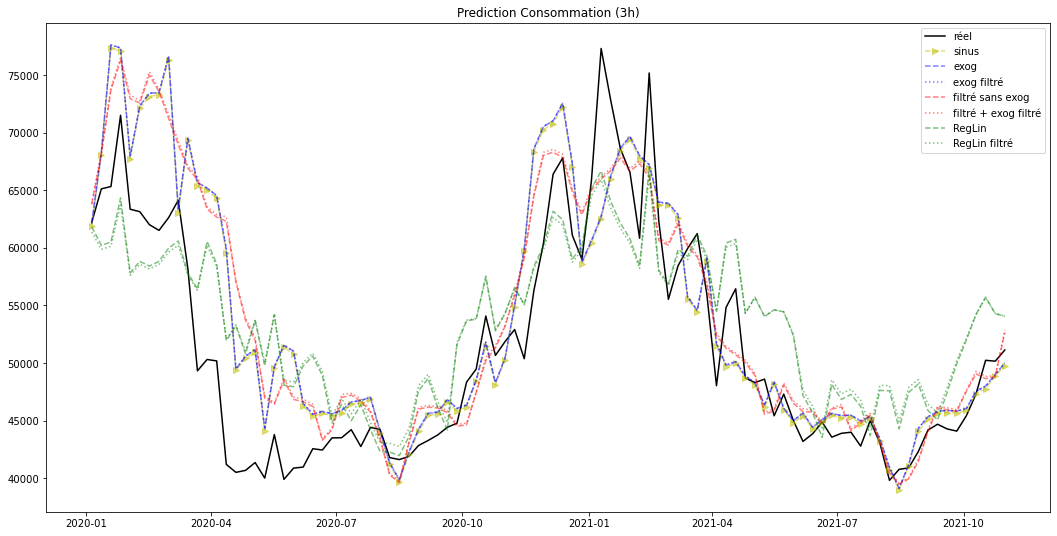

In [77]:
plt.figure(figsize=(18,9))
plt.plot(bilan['Consommation'].resample('W').mean(), color = 'k', label = 'réel')
plt.plot(bilan['Conso_p_sinus'].resample('W').mean(), color = 'y', linestyle = '--', alpha = 0.5, label = 'sinus', marker = '>')
plt.plot(bilan['Conso_p_exog'].resample('W').mean(), color = 'b', linestyle = '--', alpha = 0.5, label = 'exog')
plt.plot(bilan['Conso_p_filter'].resample('W').mean(), color = 'b', linestyle = ':', alpha = 0.5, label = 'exog filtré')
plt.plot(bilan['Conso_p_reduit_noreg'].resample('W').mean(), color = 'r', linestyle = '--', alpha = 0.5, label = 'filtré sans exog')
plt.plot(bilan['Conso_p_reduit'].resample('W').mean(), color = 'r', linestyle = ':', alpha = 0.5, label = 'filtré + exog filtré')
plt.plot(bilan['Conso_p_LinReg'].resample('W').mean(), color = 'g', linestyle = '--', alpha = 0.5, label = 'RegLin')
plt.plot(bilan['Conso_p_LinReg_filter'].resample('W').mean(), color = 'g', linestyle = ':', alpha = 0.5, label = 'RegLin filtré')
plt.legend(loc = 'upper right')
plt.title('Prediction Consommation (3h)')
plt.savefig('./results/pred_consommation_3h.png');

# Synthèse des erreurs

In [78]:
erreur = bilan[['Err_sinus',
       'Err_exog',
        'Err_exog_filter',
       'Err_filter_noreg',
        'Err_filter_exog_filter',
       'Err_LinReg',
        'Err_LinReg_filter'
      ]].describe()
erreur

,Err_sinus,Err_exog,Err_exog_filter,Err_filter_noreg,Err_filter_exog_filter,Err_LinReg,Err_LinReg_filter
count,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000,5360.000000
mean,6013.438265,6142.650396,6185.236567,5641.889345,5855.293656,7429.970556,7423.542374
std,5296.848785,5366.287928,5366.941474,4902.289142,5011.123701,5261.916358,5270.430154
min,1.474872,1.132303,0.019057,1.237165,0.405391,1.846277,0.031956
25%,1910.676489,2020.339979,2048.251754,1936.321468,2079.983700,3165.826713,3084.057922
50%,4483.259804,4498.261787,4585.171647,4201.379450,4545.047521,6512.303039,6473.742795
75%,8671.927843,9070.965385,9058.466978,8073.102225,8475.750953,10858.407630,10840.142287
max,28885.081967,28874.674981,29839.671293,30607.294978,32079.567988,25759.720800,25693.477438


In [79]:
bilan.to_csv('./results/bilan_consommation_3h.csv', sep = ';')
erreur.to_csv('./results/erreur_consommation_3h.csv', sep = ';')